In [24]:
from torchvision.utils import *
from torch.utils.data import *
from torchvision import datasets, transforms

import torchvision
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt

import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
import numpy as np

def showimg(img):
#     img = img #/ 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [28]:
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

ds_content = datasets.ImageFolder(root='data/real', transform=tf)
ds_style = datasets.ImageFolder(root='data/anime',transform=tf)
content = DataLoader(ds_content, batch_size=1)
style = DataLoader(ds_style, batch_size=1)

In [36]:
ds_c = iter(content)
ds_s = iter(style)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


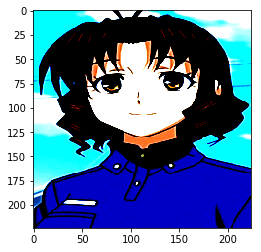

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


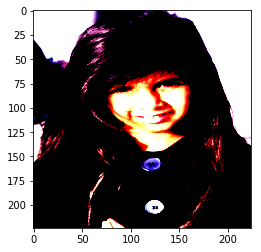

In [45]:
# a bit ugly :)
content_img = next(ds_c)
style_img = next(ds_s)

showimg(style_img[0].squeeze())
showimg(content_img[0].squeeze())

In [39]:
# load pre trained vgg model

# cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [41]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        # style transfer can happen after each conv2d layer
#         i = 0
#         for layer in cnn.children():    
#             if(isinstance(layer, nn.Conv2d)):
#                 print(i)
#             i = i + 1 //this can be a layer after max pool in the conv layer
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

Step [100/2000], Content Loss: 28.5036, Style Loss: 116.6914


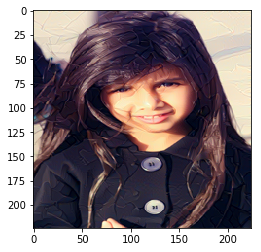

Step [200/2000], Content Loss: 34.5359, Style Loss: 83.3213


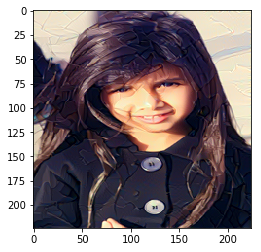

Step [300/2000], Content Loss: 37.5835, Style Loss: 67.9174


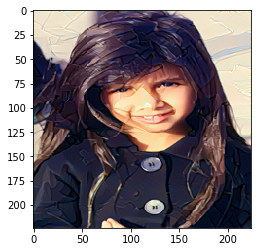

Step [400/2000], Content Loss: 39.6556, Style Loss: 57.7464


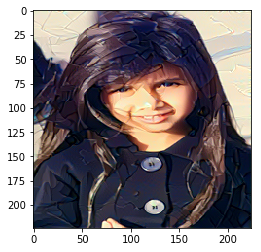

Step [500/2000], Content Loss: 41.2781, Style Loss: 50.1707


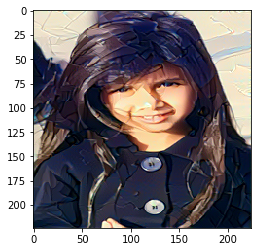

Step [600/2000], Content Loss: 42.6330, Style Loss: 44.0410


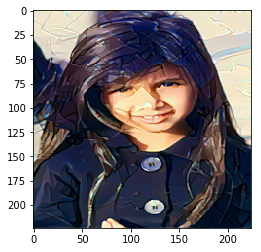

Step [700/2000], Content Loss: 43.7754, Style Loss: 38.9308


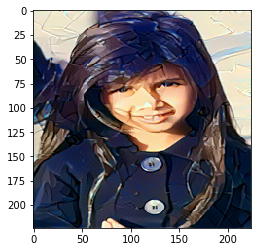

Step [800/2000], Content Loss: 44.7534, Style Loss: 34.5408


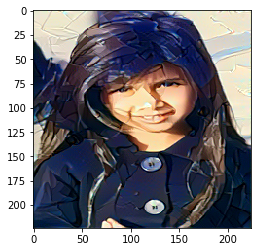

Step [900/2000], Content Loss: 45.5453, Style Loss: 30.7314


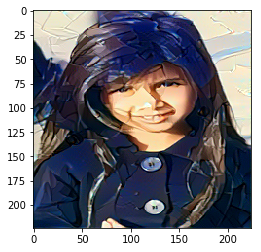

Step [1000/2000], Content Loss: 46.2508, Style Loss: 27.4150


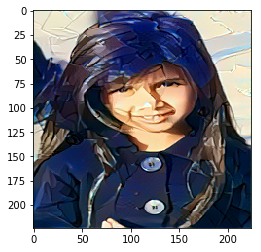

Step [1100/2000], Content Loss: 46.9254, Style Loss: 24.5759


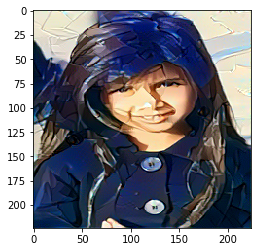

Step [1200/2000], Content Loss: 47.6196, Style Loss: 22.1819


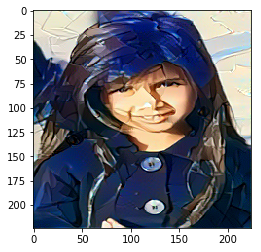

Step [1300/2000], Content Loss: 48.2622, Style Loss: 20.1974


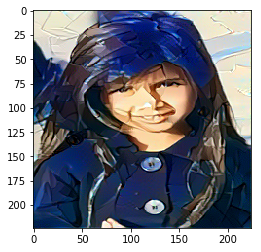

Step [1400/2000], Content Loss: 48.8312, Style Loss: 18.5572


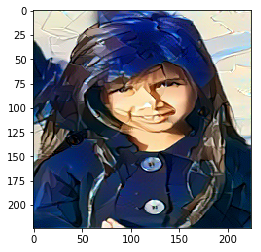

Step [1500/2000], Content Loss: 49.3742, Style Loss: 17.1835


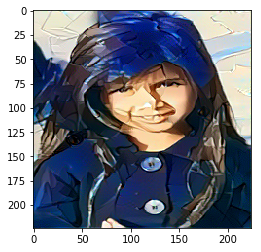

Step [1600/2000], Content Loss: 49.8863, Style Loss: 16.0114


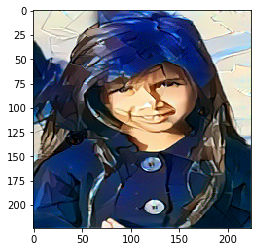

In [ ]:
style_weight = 100

content = content_img[0]
style = style_img[0]
target = content_img[0].clone().requires_grad_(True)

optimizer = torch.optim.Adam([target], lr = 0.002, betas=[0.5, 0.999])
vgg = VGGNet().to(device).eval()

steps = 2000

for step in range(steps):
    
    #extract features for all 5 layers (Conv2D) selected in VGGNET after each MaxPoollayer
    target_features = vgg(target.to(device))
    content_features = vgg(content.to(device))
    style_features = vgg(style.to(device))
    
    style_loss = 0
    content_loss = 0
    
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        # compute content loss
        content_loss += torch.mean((f1 - f2)**2)
        
        # reshape feature maps
        _, c, h, w = f1.size() #(1, 64, img_h_size, img_w_size)
        f1 = f1.view(c, h * w)
        f3 = f3.view(c, h * w)
        
        # compute gram matrix
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        
        # compute style loss
        style_loss += torch.mean(((f1 - f3)**2) / (c * h * w))
        
    # total loss with style weight default is 100
    loss = content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step+1) % 100 == 0:
        print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
               .format(step+1, steps, content_loss.item(), style_loss.item()))

        # Save the generated image
        denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
        img = target.clone().squeeze()
        img = denorm(img).clamp_(0, 1)
        
        showimg(img.data)
    

torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))
    

In [25]:
torchvision.utils.save_image(img, 'output-00-{}.png'.format(step+1))